In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import windows

%matplotlib widget

In [28]:
gamma = np.load("gamma_r.npy")
freq = np.linspace(1, 125, num=gamma.size)

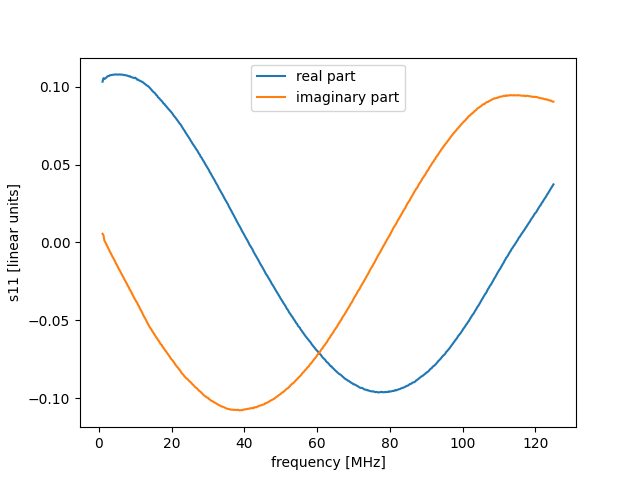

In [13]:
plt.figure()
plt.plot(freq, gamma.real, label="real part")
plt.plot(freq, gamma.imag, label="imaginary part")
plt.legend()
plt.xlabel("frequency [MHz]")
plt.ylabel("s11 [linear units]")
plt.show()

https://github.com/HERA-Team/hera_filters/blob/297dccef5a39fa3d5f087bbdb192964fba1abf1a/hera_filters/dspec.py#L2595C29-L2595C111

In [35]:
def Amat(x, nterms, fc, fhw):
    """
    Parameters
    ----------
    x : frequencies
    nterms : number of dpss modes to fit
    fc : filter center (inverse frequency units)
    fhw : filter half width (inverse frequency units)

    Returns
    -------
    A : design matrix
    
    """
    nf = x.size  # number of frequencies
    bandwidth = x[-1] - x[0]
    xc = x[nf // 2]  # center frequency
    exp_arg = 2j * np.pi * (x[:, None] - xc) * fc
    dpss = windows.dpss(nf, bandwidth * fhw, Kmax=nterms).T
    return dpss * np.exp(exp_arg)

def least_squares(A, y):
    """
    Find the solution to Ax = y by minimizing least squares.
    """
    Q, R = np.linalg.qr(A)
    xhat = np.linalg.solve(R, Q.T @ y)
    return xhat

https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.signal.windows.dpss.html#scipy.signal.windows.dpss

The scipy documentation says that the second argument to dpss, NW, is the standardized half bandwidth given by $NW = BW \times M \times dt / 2$. Since $M$ is the number of frequency channels, I interpret $BW$ as the width of one frequency channel. HERA-filters write $NW = nf \times df \times fhw$, with $nf = M$ (number of frequencies), $df = BW$ (channel width), and therefore $fhw = dt /2$.

Not sure what $fc$ (filter center) is doing. If we set it to 0, the effect of it goes away as the complex exponential is just 1.

In [38]:
def fit(nterms, fc, fhw, x=freq, y=gamma):
    A = Amat(x, nterms, fc, fhw)
    xhat = least_squares(A, y)
    yhat = A @ xhat
    return yhat

def plot(x, y, fit, nterms=None):
    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, sharex=True, sharey="row")
    axs[0, 0].plot(x, y.real, label="Data")
    axs[0, 1].plot(x, y.imag)
    axs[0, 0].set_title("Real")
    axs[0, 1].set_title("Imaginary")
    axs[0, 0].set_ylabel("S11")
    label = "Fit"
    if nterms:
        label = label + f", {nterms=}"
    axs[0, 0].plot(x, fit.real, ls="--", label=label)
    axs[0, 1].plot(x, fit.imag, ls="--")
            
    res = y - fit
    axs[1, 0].plot(x, res.real)
    axs[1, 1].plot(x, res.imag)
    axs[1, 0].set_ylabel("Residuals")
    axs[0, 0].legend()
    plt.setp(axs[-1], xlabel="Frequency [MHz]")

fhw = 2.0 microseconds


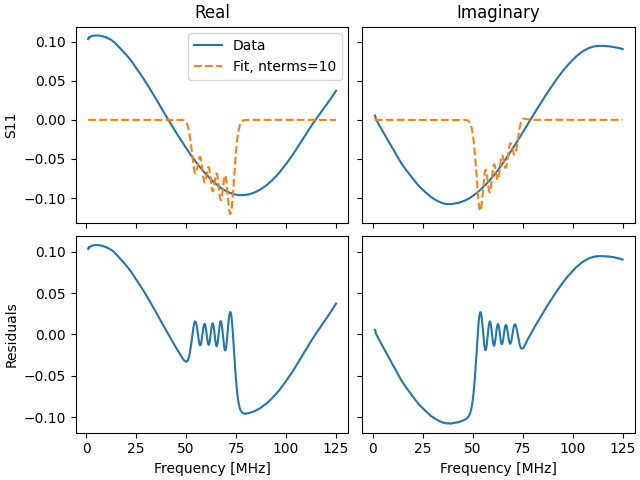

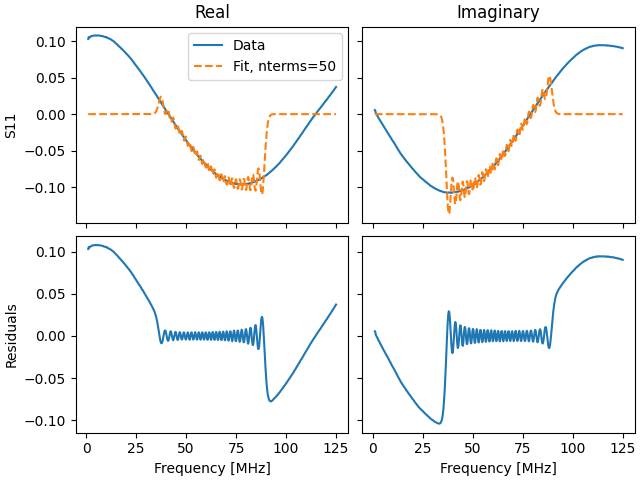

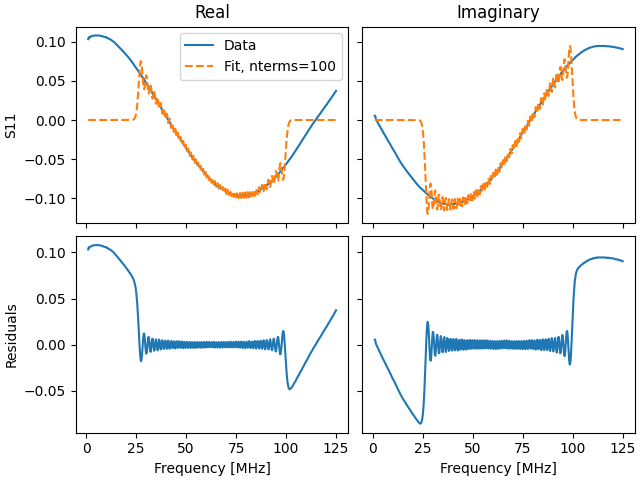

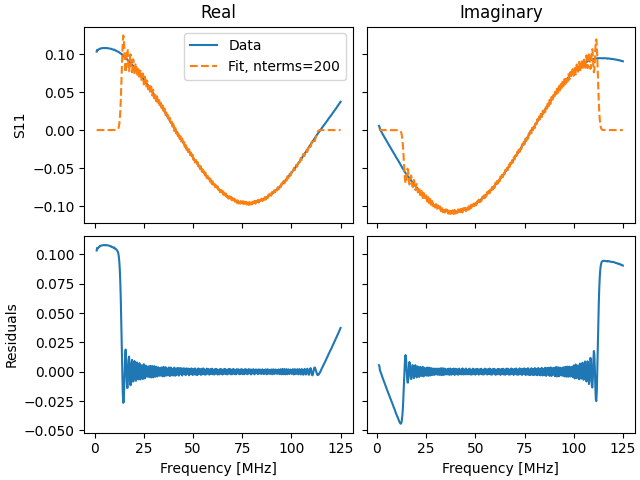

In [40]:
# we take fhw = dt / 2
df = freq[1] - freq[0]
dt = 1/df
fhw = dt/2
print(f"fhw = {fhw.item()} microseconds")

# first we do fc = 0 and vary nterms
fc = 0

nterms = [10, 50, 100, 200]
for n in nterms:
    mdl = fit(n, fc, fhw)
    plot(freq, gamma, mdl, nterms=n)

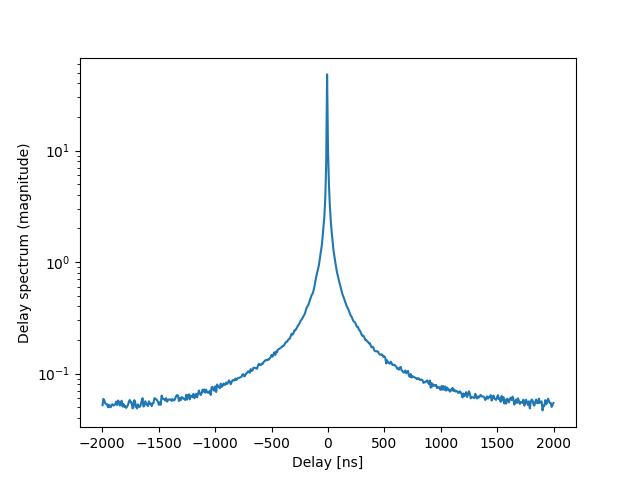

In [58]:
# to gain some intuition, we look at the spectrum in delay space

_gamma = np.fft.fft(gamma)
dlys = np.fft.fftfreq(gamma.size, d=df)

plt.figure()
plt.plot(np.fft.fftshift(dlys) * 1e3, np.fft.fftshift(np.abs(_gamma)))
plt.xlabel("Delay [ns]")
plt.ylabel("Delay spectrum (magnitude)")
plt.yscale("log")
plt.show()

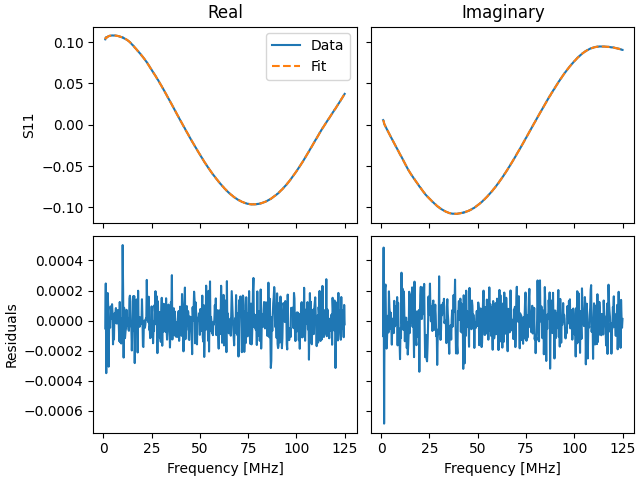

In [61]:
# looks like the spectrum is described well by delays of += 100 ns from 0
max_dly = 0.1  # 100 ns = 0.1 microseconds
fc = 0
fhw = max_dly / 2
nterms = 50
mdl = fit(nterms, fc, fhw)
plot(freq, gamma, mdl)